<a href="https://colab.research.google.com/github/UdeS-PMF/gmq710_test/blob/develop/a2024_gmq710_firststep_suite2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utiliser Colab en analyse d'image

Appliquer un K-means sur une image satellitaire
En utilisant l'image de 3 bandes (BEN_satellite.tif), on souhaite obtenir une image segmentée avec 6 classes.

On peut se baser sur le code vu en classe.

On aimerait connaître le nombre de pixels de chaque classe. Trouver un moyen avec Numpy.

## Importer les libs

Si nécessaire, installer d'autres libs

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.1 MB/s eta 0:00:00


In [ ]:
# j'importe les libs
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Lire l'image

In [ ]:
# Connecter un répertoire de google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Si nécessaire, vous pouvez dézipper l'image

In [ ]:
!unzip /content/drive/MyDrive/a2024-gmq710/BEN_satellite_TIF.zip

Archive:  /content/drive/MyDrive/a2024-gmq710/BEN_satellite_TIF.zip
  inflating: BEN_satellite_TIF/BEN_satellite.tfw  
  inflating: BEN_satellite_TIF/BEN_satellite.tif  


On va lire l'image avec rasterio

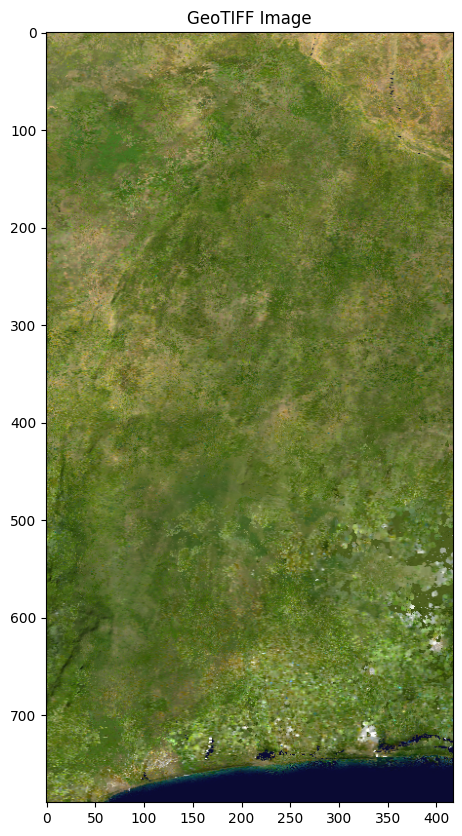

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Lire l'image GeoTIFF
tif_path = '/content/BEN_satellite_TIF/BEN_satellite.tif'

# on lit les bandes
with rasterio.open(tif_path) as src:
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
    image = np.stack((r, g, b), axis=-1)


plt.figure(figsize=(10, 10))

plt.title("GeoTIFF Image")
plt.imshow(image)

In [ ]:
image.shape

(790, 417, 3)

In [ ]:
# transformer la matrice image en une seule ligne image_array
h, w, d = image.shape

image_array = image.reshape(-1, d)
# normalisation
image_array = image_array / 255.0 if image_array.max() > 1 else image_array

image_array

array([[0.57254902, 0.68627451, 0.57647059],
       [0.62745098, 0.55294118, 0.36078431],
       [0.63921569, 0.56862745, 0.38823529],
       ...,
       [0.03921569, 0.03921569, 0.2       ],
       [0.03921569, 0.03921569, 0.2       ],
       [0.03921569, 0.03921569, 0.2       ]])

Pour utiliser K-means, il faut prendre des échantillons de l'image pour créer des groupes

In [ ]:
# je vais créer un jeu de 1000 échantillons
img_sample = shuffle(image_array, random_state=0)[:1000]
# j'entraîne K-means pour 7 clusters
nb_classes = 3
kmeans = KMeans(n_clusters=nb_classes, random_state=0).fit(img_sample)

On utilise le modèle pour prédire les classes des pixels restants

In [ ]:
# j'estime pour l'ensemble de l'image
resu = kmeans.predict(image_array)
# je récupère la dimension d'un centre (normalement c'est 3)
d = kmeans.cluster_centers_.shape[1]
# je reforme l'image, autrement dit je découpe
# la grande ligne pour retrouver l'image originale
outimage = np.reshape(resu, (h,w)) #np.zeros((w, h, d))

kmeans.cluster_centers_

array([[0.34875817, 0.42084489, 0.15210585],
       [0.51274217, 0.5351712 , 0.2970559 ],
       [0.04376471, 0.06980392, 0.20831373]])

On va créer une image avec les couleurs originales

In [ ]:
outimage_rgb = np.zeros((h, w, d))

idx = 0

# on parcourt les pixels et on va créer l'image de sortie
for i in range(h):
    for j in range(w):
        # on affecte pour chaque pixel, la valeur du cluster
        # on divise par 255 pour obtenir une valeur entre 0 et 1
        outimage_rgb[i][j] = kmeans.cluster_centers_[resu[idx]]
        idx += 1

On affiche les résultats

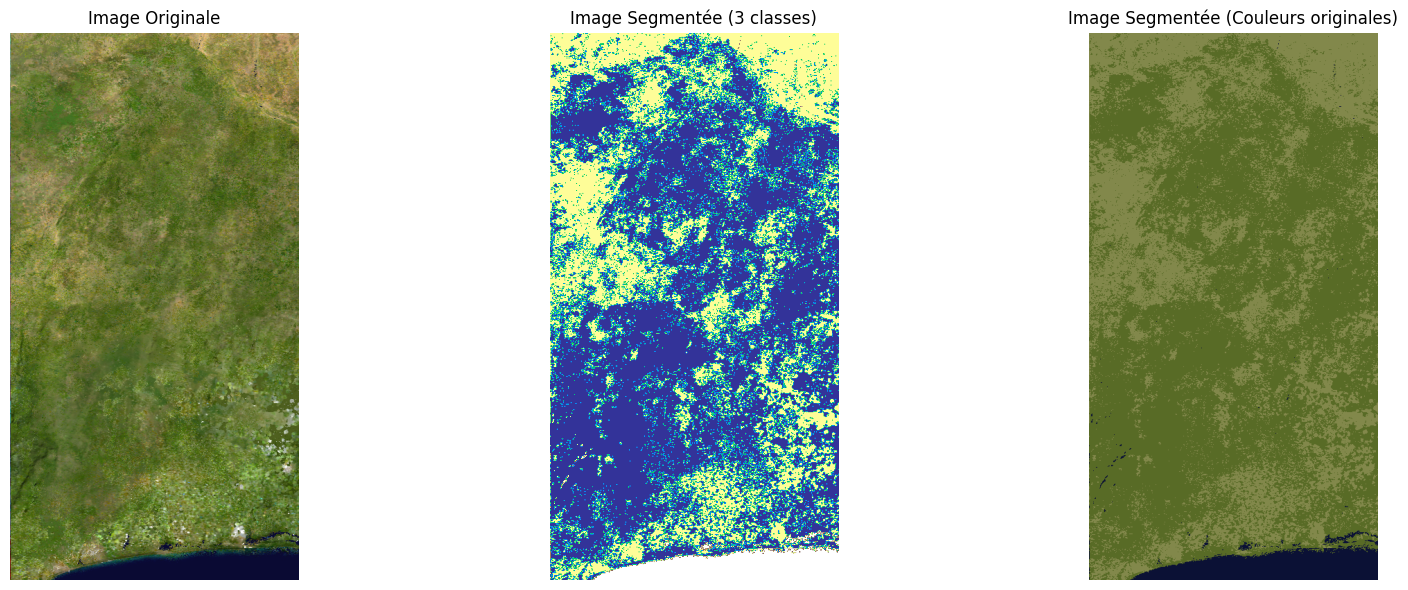

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Image originale
#image = np.transpose(image, (1, 2, 0))
ax[0].imshow(image)
ax[0].set_title("Image Originale")
ax[0].axis("off")

# Image segmentée (en niveaux de gris)
ax[1].imshow(outimage, cmap='terrain')
ax[1].set_title(f"Image Segmentée ({nb_classes} classes)")
ax[1].axis("off")

# Image segmentée avec des couleurs aléatoires
ax[2].imshow(outimage_rgb)
ax[2].set_title("Image Segmentée (Couleurs originales)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# comptabiliser le nombre de pixels de chaque classe dans outimage

# Calcul du nombre de pixels par classe
pixel_counts = np.bincount(outimage.flatten())

# Affichage des résultats
for i, count in enumerate(pixel_counts):
  print(f"Classe {i}: {count} pixels")

Classe 0: 203897 pixels
Classe 1: 112349 pixels
Classe 2: 13184 pixels


# Appliquer une autre méthode

Il suffit d'utiliser l'image originale et d'appliquer une autre méthode de scikit-learn (comme Gaussian Mixture Model (GMM) )



In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
labels = gmm.fit_predict(image_array)

segmented_image = labels.reshape(image.shape[:2])

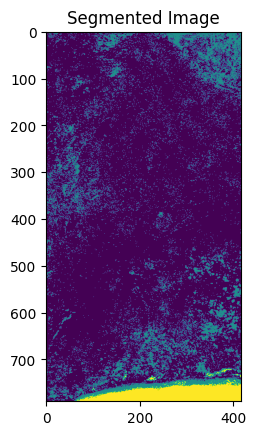

In [ ]:
# afficher segmented_image

plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.show()

In [ ]:
# prompt: compter le nombre de pixels par classe

# Calcul du nombre de pixels par classe dans outimage
unique_classes, pixel_counts = np.unique(outimage, return_counts=True)

# Affichage des résultats
for class_label, count in zip(unique_classes, pixel_counts):
  print(f"Classe {class_label}: {count} pixels")

Classe 0: 203897 pixels
Classe 1: 112349 pixels
Classe 2: 13184 pixels
